The goal for today is to make a chart. Since I'm romanian and there recently was an election (first presidential tour) in a future post I'd like to make a visual representation of various statistics of how that went. 

Some of these charts should present the different values for different counties on a single map, but in order to do that I need to gain one skill that I'm missing:
```drawing data on a map```

Such a map goes by the name of a [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map).

By the end of this exercise I need to be able to plot a map of Romania, on a county level basis and color each conty in a different color according to a certain value that I'm computing.

# GeoPandas

After some googling around I've [found](https://scitools.org.uk/cartopy/docs/latest/) [various](https://shapely.readthedocs.io/en/latest/) [possible](https://matplotlib.org/basemap/) [tools](https://plot.ly/python/choropleth-maps/) that people have been using in order to draw charts.

One of the more promising (simple) ones seemed to be [`GeoPandas`](http://geopandas.org/)

Installing it only meant on doing:

```python
pip install geopandas
pip install descartes
```

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

# Getting a map

GeoPandas doesn't come (or I couldn't find them) with bundled maps. And to be honest, even if it had, I doubt that `Romania` would be included out of the box. 

To actually show a map, you need to download a ploygon representation of it. These polygon files can be found online. For example I've found the map I was looking for [here](https://gadm.org/download_country_v3.html).

If turns out though that there are many format of maps. Most tutorials online ([this one](https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d) for example) suggest using `shp` (shape) files.

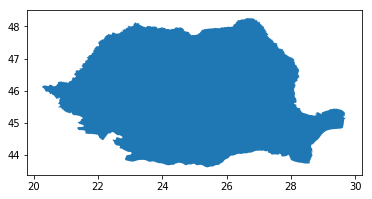

In [3]:
map_df = gpd.read_file("./gadm36_ROU_shp/gadm36_ROU_0.shp")
map_df.plot()

Using the shapely files seems to only contain the outline of the country. This is evidenced by using `head()` and noticing that we have a single entry for `Romania`. 

In [88]:
map_df.head()

,GID_0,NAME_0,geometry
0,ROU,Romania,"MULTIPOLYGON (((29.59375 44.83014, 29.59375 44..."


According to [1](https://en.wikipedia.org/wiki/GeoPackage), `GeoPackage` format is a more modern standard :
> Despite dozens of file formats and services for exchanging geospatial data, there was not an open format which could support both raster and vector data, while being efficiently decodable by software, particularly in mobile devices. This need was formally expressed at the OGC in 2012. The candidate standard was approved by the OGC in February 2014.

So let's see what we can get this file format (from the same download page).

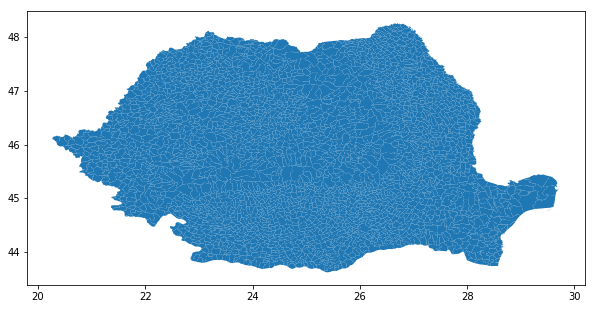

In [4]:
map_df = gpd.read_file("./gadm36_ROU.gpkg")
map_df.plot(figsize=(10, 10))

Great! The granularity we have now is really good. Actually I can say that there's too much granularity..

In [91]:
map_df.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,ROU,Romania,ROU.1_1,Alba,None,ROU.1.1_1,Abrud,Oras Abrud,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.11756 46.26924, 23.10890 46..."
1,ROU,Romania,ROU.1_1,Alba,None,ROU.1.2_1,Aiud,Municipiul Aiud,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.68714 46.24480, 23.68568 46..."
2,ROU,Romania,ROU.1_1,Alba,None,ROU.1.3_1,Alba Iulia,Municipiul Alba Iulia,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.62130 46.11345, 23.61981 46..."
3,ROU,Romania,ROU.1_1,Alba,None,ROU.1.4_1,Albac,None,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.02857 46.50118, 23.02879 46..."
4,ROU,Romania,ROU.1_1,Alba,None,ROU.1.5_1,Almasu Mare,None,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.16239 46.03325, 23.16147 46..."


In [92]:
map_df.shape

(2939, 14)

Each line represents a city or village and has its own polygon, name, county and official name, along with other types of meta-data. Turns out that `GeoPandas` recognizes the contents of the geometry field automatically and converts it to a `shapely.geometry.multipolygon.MultiPolygon` instance. (Note to self: dig into `shapely` in a future exercise).

Even more interesting is that trying to output a `MultiPolygon` in Jupyter yields an actual image (I was expecting some coordinates representing the shape). 

<class 'shapely.geometry.multipolygon.MultiPolygon'>


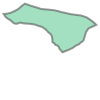

In [22]:
print(type(map_df.geometry.iloc[0]))
map_df.geometry.iloc[0]

## Quick `Shapely` digression

Since we are here, let's quickly try to play with the `MultiPolygon` class and try to draw something..

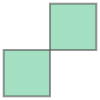

In [101]:
from shapely.geometry.polygon import Polygon
coordinates = np.array([(0., 0.), (0., 1.), (1., 1.), (1., 0.), (0., 0.)])
MultiPolygon(polygons=[Polygon(coordinates), Polygon(coordinates + 1)])

It's pretty intuitive if you ask me. `Polygon` defines a single shape. `MultiPolygon` defines a grouping of `Polygons`. 

In our example we've defined a closed polygon (the first and last coordinates were equal, so we've ended up where we've started). I wonder what happens when you have an open shape (where your coordinates don't define a closed shape). The example bellow uses only the first 3 coordinates from the previous example.

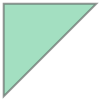

In [104]:
Polygon(coordinates[:3])

Basically, `shapely` will take care of closing the shape for us, which is very useful!

# Grouping by counties

I'm actually interested in counties so we must group all the shapes of a single county into one. Setting the county field as an index should be a good first step.

In [16]:
map_df.set_index('NAME_1').head()

,GID_0,NAME_0,GID_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
NAME_1,,,,,,,,,,,,,
Alba,ROU,Romania,ROU.1_1,None,ROU.1.1_1,Abrud,Oras Abrud,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.11756 46.26924, 23.10890 46..."
Alba,ROU,Romania,ROU.1_1,None,ROU.1.2_1,Aiud,Municipiul Aiud,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.68714 46.24480, 23.68568 46..."
Alba,ROU,Romania,ROU.1_1,None,ROU.1.3_1,Alba Iulia,Municipiul Alba Iulia,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.62130 46.11345, 23.61981 46..."
Alba,ROU,Romania,ROU.1_1,None,ROU.1.4_1,Albac,None,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.02857 46.50118, 23.02879 46..."
Alba,ROU,Romania,ROU.1_1,None,ROU.1.5_1,Almasu Mare,None,None,Comune,Commune,None,None,"MULTIPOLYGON (((23.16239 46.03325, 23.16147 46..."


`Shapely`'d documentation mentions that joining two `MultyPoligons` is done by using the `union` method on one object using the other as a param and this seems to work.

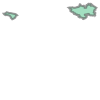

In [24]:
map_df.geometry.iloc[0].union(map_df.geometry.iloc[1])

Why the `+` operator wasn't defined is a bit of a mistery but I assume this is because there are multiple ways to join two figures. 

![image.png](http://geopandas.org/_images/overlay_operations.png)

Let's use the regular `groupby` method of a Pandas `DataFrame` (which `GeoPandas` replicates) and hope we can use the default (`sum`) aggregation to join these.

/Users/cristi/Envs/deep3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/cristi/Envs/deep3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/cristi/Envs/deep3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until

NAME_1
Alba               AxesSubplot(0.155583,0.125;0.713834x0.755)
Arad               AxesSubplot(0.125,0.280914;0.775x0.443172)
Argeș               AxesSubplot(0.32812,0.125;0.368761x0.755)
Bacău              AxesSubplot(0.125,0.194565;0.775x0.615869)
Bihor               AxesSubplot(0.22438,0.125;0.576239x0.755)
Bistrița-Năsăud    AxesSubplot(0.169417,0.125;0.686165x0.755)
Botoșani            AxesSubplot(0.125,0.13057;0.775x0.743859)
Brașov             AxesSubplot(0.125,0.181411;0.775x0.642178)
Brăila             AxesSubplot(0.129139,0.125;0.766723x0.755)
Bucharest          AxesSubplot(0.180867,0.125;0.663265x0.755)
Buzău              AxesSubplot(0.189831,0.125;0.645337x0.755)
Caraș-Severin      AxesSubplot(0.196658,0.125;0.631684x0.755)
Cluj               AxesSubplot(0.125,0.142697;0.775x0.719606)
Constanța          AxesSubplot(0.125,0.141711;0.775x0.721577)
Covasna            AxesSubplot(0.183247,0.125;0.658506x0.755)
Călărași           AxesSubplot(0.125,0.317438;0.775x0.370125)
D

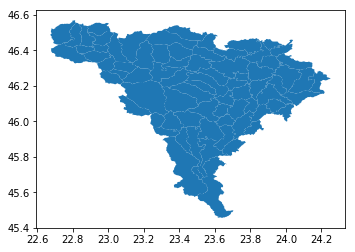

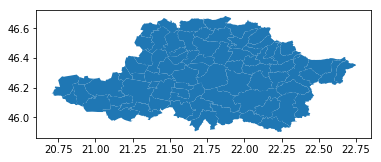

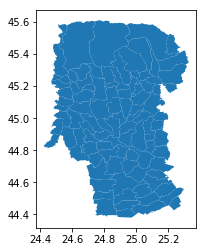

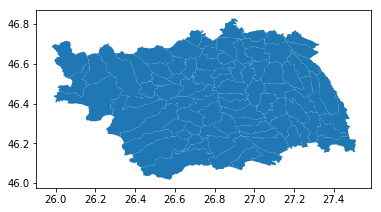

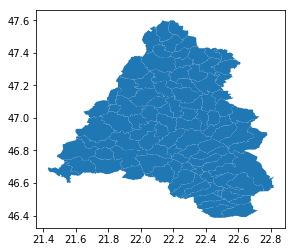

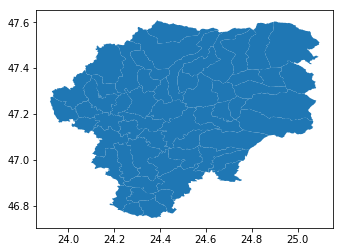

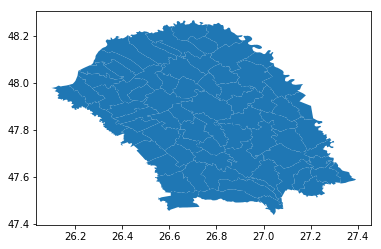

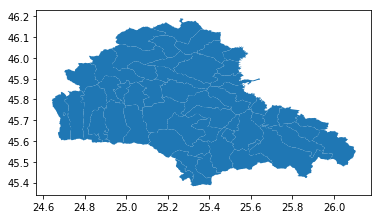

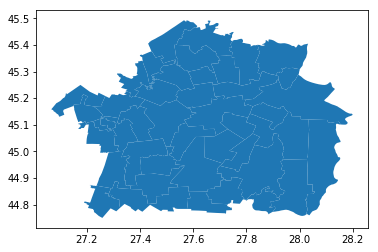

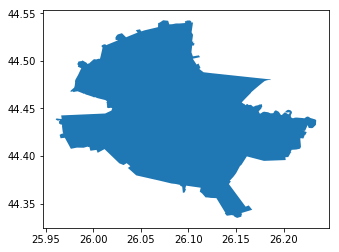

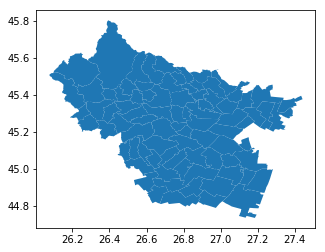

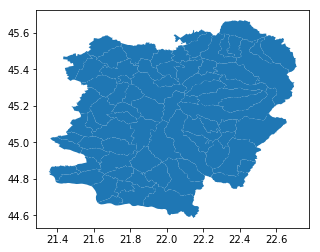

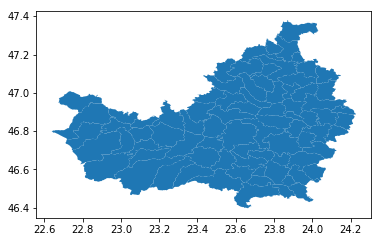

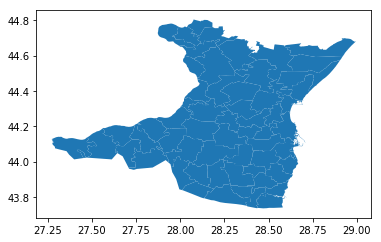

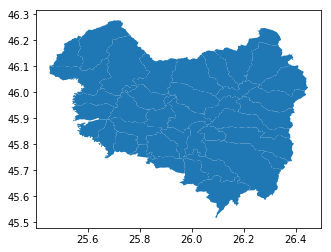

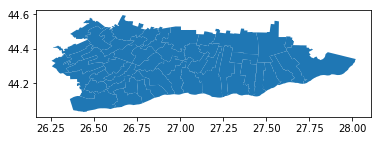

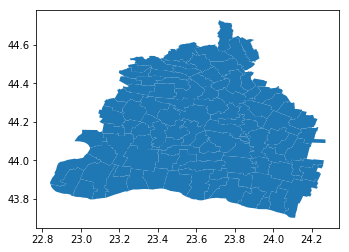

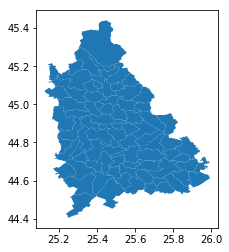

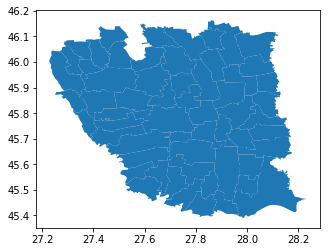

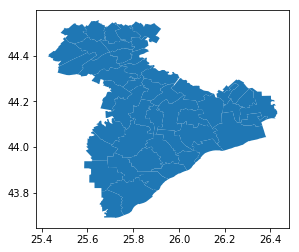

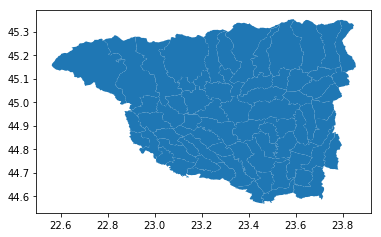

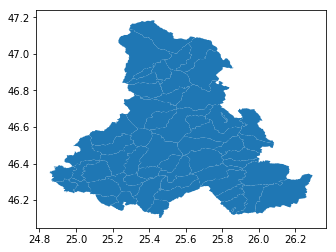

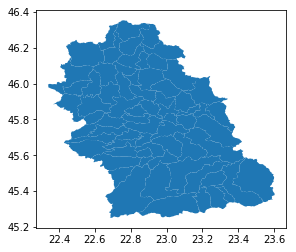

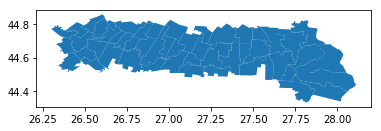

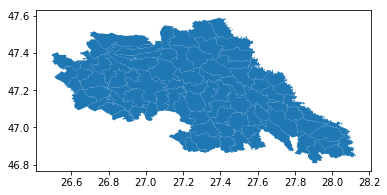

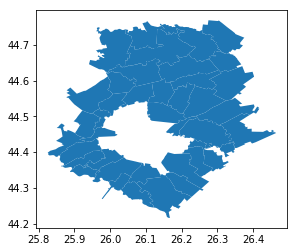

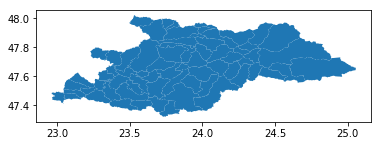

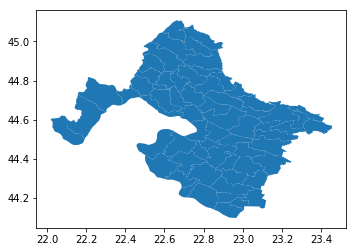

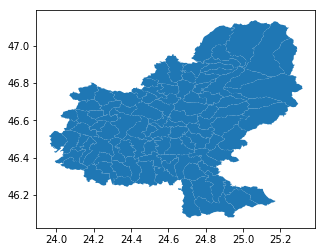

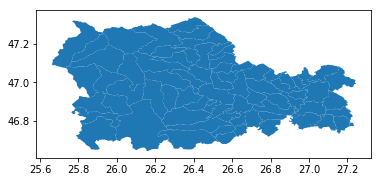

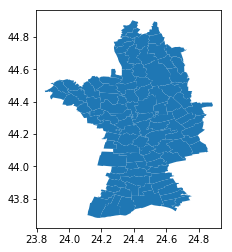

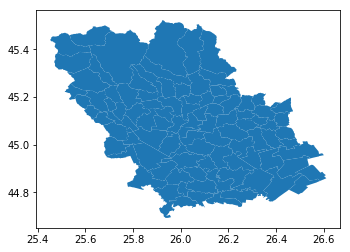

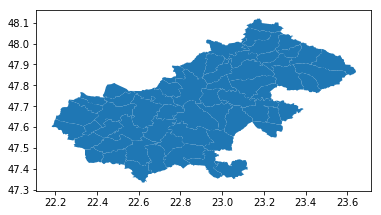

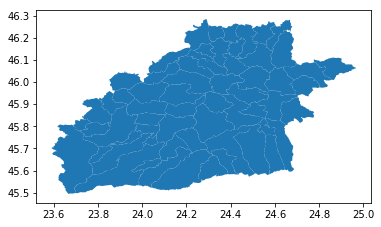

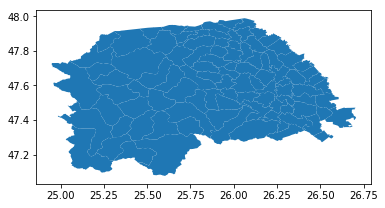

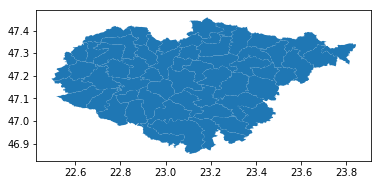

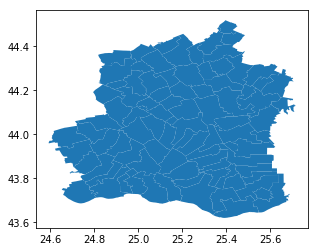

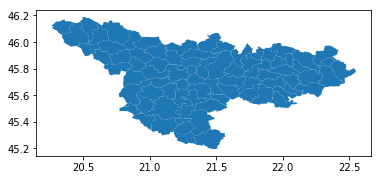

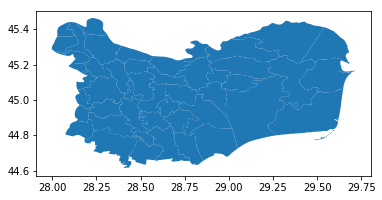

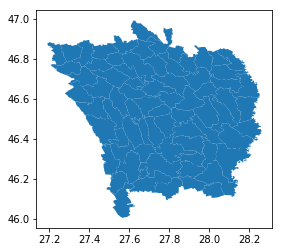

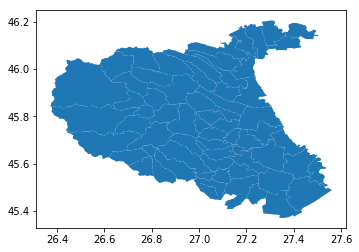

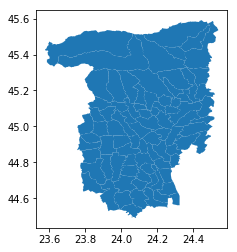

In [109]:
map_df.groupby(by='NAME_1').geometry.plot()

This does seem to work on joining the figures but it actually plots all the groups in individual axis. What we want is to group then in a new `GeoPandas` `DataFrame` that we can later us to display all of them on the same axis. We can try to force the groups in order to achieve that by dropping an abstraction level and go on pure `matplotlib` where after you define a figure and an axis you can pass that axis to the `plot()` method.

This will make all the plots be drawn on the same figure but as you can see bellow, we're not getting `MultiPolygons` merged. We only have them grouped in the same plot, and we force them all to be dranw on the same axis we end up were we've started from (drawing all the small cities and villages).

NAME_1
Alba               AxesSubplot(0.125,0.216909;0.775x0.571182)
Arad               AxesSubplot(0.125,0.216909;0.775x0.571182)
Argeș              AxesSubplot(0.125,0.216909;0.775x0.571182)
Bacău              AxesSubplot(0.125,0.216909;0.775x0.571182)
Bihor              AxesSubplot(0.125,0.216909;0.775x0.571182)
Bistrița-Năsăud    AxesSubplot(0.125,0.216909;0.775x0.571182)
Botoșani           AxesSubplot(0.125,0.216909;0.775x0.571182)
Brașov             AxesSubplot(0.125,0.216909;0.775x0.571182)
Brăila             AxesSubplot(0.125,0.216909;0.775x0.571182)
Bucharest          AxesSubplot(0.125,0.216909;0.775x0.571182)
Buzău              AxesSubplot(0.125,0.216909;0.775x0.571182)
Caraș-Severin      AxesSubplot(0.125,0.216909;0.775x0.571182)
Cluj               AxesSubplot(0.125,0.216909;0.775x0.571182)
Constanța          AxesSubplot(0.125,0.216909;0.775x0.571182)
Covasna            AxesSubplot(0.125,0.216909;0.775x0.571182)
Călărași           AxesSubplot(0.125,0.216909;0.775x0.571182)
D

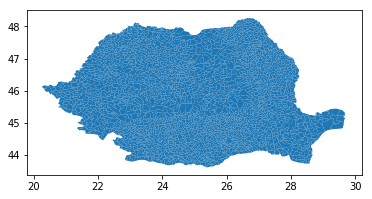

In [107]:
from matplotlib import pyplot as plt

fix, ax = plt.subplots()
map_df.groupby(by='NAME_1').geometry.plot(ax=ax)

According to the [documentation](http://geopandas.org/aggregation_with_dissolve.html), the `groupby` route is not the one recommended. Instead, you need to call the `dissolve` function. 

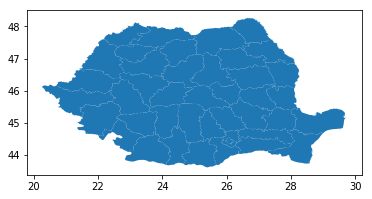

In [43]:
map_df[['NAME_1', 'geometry']].dissolve(by="NAME_1", aggfunc='sum').plot()

The last step is to color the merged shapes (counties) by different colors. This can be done by setting a new column in the `GeoDataFrame` resulted after the `dissolve` call with these values and using it in the `plot` method. 

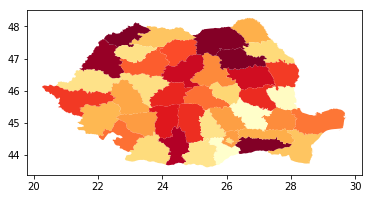

In [5]:
romania_by_county = map_df[['NAME_1', 'geometry']].dissolve(by="NAME_1", aggfunc='sum')
romania_by_county['numbers'] = np.random.randint(10, 1000, size=(romania_by_county.shape[0]))
_map = romania_by_county.plot(column='numbers', cmap='YlOrRd')
_map

# Animating the changes on the map

The last thing that would be great is if we could create an animation of the changes occurring over time. The code bellow actually accomplishes that even though generating it (100 frames) took around 3 minutes.

In [9]:
from matplotlib import animation, rc
from IPython.display import HTML

def init():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    romania_by_county['numbers'] = np.random.randint(10, 1000, size=(romania_by_county.shape[0]))
    romania_by_county.plot(column='numbers', cmap='YlOrRd', ax=ax)

    fig.tight_layout()
    return fig, ax

def animate(i, ax):
    ax.set_title(f"Step {i} comp.")
    romania_by_county['numbers'] = np.random.randint(10, 1000, size=(romania_by_county.shape[0]))
    romania_by_county.plot(column='numbers', cmap='YlOrRd', ax=ax)
#     return [plot]

fig, ax = init()
anim = animation.FuncAnimation(fig, animate, fargs=(ax,), frames=100, interval=100, blit=False)
display(HTML(anim.to_html5_video()))
plt.close()

# Conclusions

* `GeoPandas` 
    * is easy to use
    * handles `shapely` polygons for you
    * doesn't have that many dependencies
* `Shapely` 
    * is really useful for drawing new stuff
* Download maps from `https://gadm.org/download_country_v3.html`
* use the `GeoPackage` format when downloading maps
* animations are possible but take longer to generate